In [1]:
import sys
import os

# Add root directory of rhe project into sys.path
sys.path.append("/kaggle/input/license-plate-module")

## **0. Libraries**

In [2]:
from src.visualization import display_images_and_targets
from src.data_preprocessing import download_dataset, preprocess_data
from src.dataset import LicensePlateDataset
from src.model import FTFasterRCNN
from src.train import train_model
from src.evaluate import evaluate_model
from src.callbacks import EarlyStopping, ModelCheckpoints
from src.config import (
    RAW_DATA_DIR,
    PROCESSED_DATA_DIR, 
    IMAGE_SIZE, 
    MEAN_NORMALIZATION, 
    STD_NORMALIZATION,
    NUM_WORKERS,
    BATCH_SIZE,
    NUM_CLASSES,
    DEVICE,
    EPOCHES,
    LEARNING_RATE,
    WEIGHT_DECAY,
    MOMENTUM,
    STEP_SIZE,
    GAMMA
)

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

import torchinfo

import warnings
warnings.filterwarnings("ignore")

## **1. Dataset**

In [3]:
# Download dataset from Github
download_dataset(dest=RAW_DATA_DIR)

Dataset does not exist, please waiting to download data from the cloud...
Start to download...
0/20 of data are downloaded
5/20 of data are downloaded
10/20 of data are downloaded
15/20 of data are downloaded


license-plate-project.zip: 100%|██████████| 965M/965M [00:11<00:00, 89.1MB/s] 


Downloaded, please waiting to extract file...
Extracting...
Extracted!!
Removing zip file...
Removed!!
Done!!


In [4]:
# Data preprocessing
preprocess_data(RAW_DATA_DIR, PROCESSED_DATA_DIR, IMAGE_SIZE)

Preprocessing data in train folder...: 100%|██████████| 20580/20580 [00:52<00:00, 390.53it/s]


In [5]:
# Get the list of file paths in each folder
file_pathes = {}
for dir_name in os.listdir(PROCESSED_DATA_DIR):
    dir_path = os.path.join(PROCESSED_DATA_DIR, dir_name)
    file_pathes[dir_name] = []
    for filename in os.listdir(dir_path):
        file_pathes[dir_name].append(os.path.join(dir_path, filename))

In [6]:
def collate_fn(batch):
    """
    Custom collate function to handle batches with varying number of bounding boxes.
    """
    images, targets = zip(*batch)
    images = list(images)  # Keep images as a list
    targets = list(targets)  # Keep targets as a list of dictionaries
    return images, targets

In [7]:
# Transform images
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_NORMALIZATION, std=STD_NORMALIZATION)
])

# Declare dataset and dataloader
train_dataset = LicensePlateDataset(file_paths=file_pathes["train"], transform=transform)
valid_dataset = LicensePlateDataset(file_paths=file_pathes["valid"], transform=transform)
test_dataset = LicensePlateDataset(file_paths=file_pathes["test"], transform=transform)

# Split dataset to batches
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True, 
    pin_memory=True,
    shuffle=True,
    prefetch_factor=10,
    collate_fn=collate_fn
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True, 
    pin_memory=True,
    shuffle=True,
    prefetch_factor=10,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True, 
    pin_memory=True,
    shuffle=True,
    prefetch_factor=10,
    collate_fn=collate_fn
)

## **2. Faster RCNN model**

In [9]:
faster_rcnn_model = FTFasterRCNN(num_classes=NUM_CLASSES, freeze_backbone=True)
faster_rcnn_model.to(DEVICE)
torchinfo.summary(faster_rcnn_model, (3, IMAGE_SIZE[0], IMAGE_SIZE[1]), batch_dim=0, depth=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.0MB/s]


Layer (type:depth-idx)                                  Output Shape              Param #
FTFasterRCNN                                            [1, 4]                    --
├─FasterRCNN: 1-1                                       [1, 4]                    --
│    └─GeneralizedRCNNTransform: 2-1                    [1, 3, 800, 800]          --
│    └─Sequential: 2-2                                  [1, 1024, 50, 50]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─BatchNorm2d: 3-2                            [1, 64, 400, 400]         (128)
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (215,808)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        (1,219,584)
│    │    └─Sequential: 3-7         

In [10]:
optimizer = SGD(
    filter(lambda p: p.requires_grad, faster_rcnn_model.parameters()),
    lr=LEARNING_RATE, 
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)
lr_scheduler = StepLR(
        optimizer=optimizer, 
        step_size=STEP_SIZE,
        gamma=GAMMA
    )
early_stopping = EarlyStopping(patience=10)
model_checkpoints = ModelCheckpoints("faster_rcnn_checkpoints.pt")

In [ ]:
faster_rcnn_history = train_model(
                        model=faster_rcnn_model, 
                        train_dataloader=train_dataloader,
                        epoches=EPOCHES,
                        optimizer=optimizer,
                        lr_scheduler=lr_scheduler,
                        valid_dataloader=valid_dataloader,
                        early_stopping=early_stopping,
                        model_checkpoint=model_checkpoints
                )

Epoch 1/30: 100%|██████████| 1286/1286 [22:54<00:00,  1.07s/it, loss=0.286]


Validation set: Average loss: 0.2448 - Accuracy: 2854/9018 (31.65%)



Epoch 2/30: 100%|██████████| 1286/1286 [20:09<00:00,  1.06it/s, loss=0.257]


Validation set: Average loss: 0.2021 - Accuracy: 2286/6202 (36.86%)



Epoch 3/30: 100%|██████████| 1286/1286 [20:53<00:00,  1.03it/s, loss=0.221]


Validation set: Average loss: 0.1825 - Accuracy: 2098/4509 (46.53%)



Epoch 4/30: 100%|██████████| 1286/1286 [21:26<00:00,  1.00s/it, loss=0.2]  


Validation set: Average loss: 0.1723 - Accuracy: 2076/4104 (50.58%)



Epoch 5/30: 100%|██████████| 1286/1286 [21:42<00:00,  1.01s/it, loss=0.189]


Validation set: Average loss: 0.1583 - Accuracy: 2101/4216 (49.83%)



Epoch 6/30: 100%|██████████| 1286/1286 [22:12<00:00,  1.04s/it, loss=0.177]


Validation set: Average loss: 0.1587 - Accuracy: 2078/3705 (56.09%)



Epoch 7/30: 100%|██████████| 1286/1286 [22:21<00:00,  1.04s/it, loss=0.171]


Validation set: Average loss: 0.1449 - Accuracy: 2082/3694 (56.36%)



Epoch 8/30: 100%|██████████| 1286/1286 [22:54<00:00,  1.07s/it, loss=0.162]


Validation set: Average loss: 0.1374 - Accuracy: 2048/3458 (59.22%)



Epoch 9/30: 100%|██████████| 1286/1286 [23:08<00:00,  1.08s/it, loss=0.156]


Validation set: Average loss: 0.1447 - Accuracy: 2043/3495 (58.45%)



Epoch 10/30: 100%|██████████| 1286/1286 [23:15<00:00,  1.08s/it, loss=0.153]


Validation set: Average loss: 0.1407 - Accuracy: 2058/3413 (60.30%)



Epoch 11/30: 100%|██████████| 1286/1286 [22:52<00:00,  1.07s/it, loss=0.152]


Validation set: Average loss: 0.1340 - Accuracy: 2010/3165 (63.51%)



Epoch 12/30: 100%|██████████| 1286/1286 [23:08<00:00,  1.08s/it, loss=0.149]


Validation set: Average loss: 0.1326 - Accuracy: 2017/3147 (64.09%)



Epoch 13/30: 100%|██████████| 1286/1286 [23:16<00:00,  1.09s/it, loss=0.148]


Validation set: Average loss: 0.1339 - Accuracy: 2014/3113 (64.70%)



Epoch 14/30: 100%|██████████| 1286/1286 [23:06<00:00,  1.08s/it, loss=0.149]


Validation set: Average loss: 0.1302 - Accuracy: 2016/3153 (63.94%)



Epoch 15/30: 100%|██████████| 1286/1286 [23:10<00:00,  1.08s/it, loss=0.148]


Validation set: Average loss: 0.1306 - Accuracy: 2032/3215 (63.20%)



Epoch 16/30: 100%|██████████| 1286/1286 [23:22<00:00,  1.09s/it, loss=0.147]


Validation set: Average loss: 0.1316 - Accuracy: 2029/3220 (63.01%)



Epoch 17/30: 100%|██████████| 1286/1286 [23:14<00:00,  1.08s/it, loss=0.148]


Validation set: Average loss: 0.1314 - Accuracy: 2012/3174 (63.39%)



Epoch 18/30: 100%|██████████| 1286/1286 [23:20<00:00,  1.09s/it, loss=0.147]


Validation set: Average loss: 0.1337 - Accuracy: 2018/3231 (62.46%)



Epoch 19/30: 100%|██████████| 1286/1286 [23:11<00:00,  1.08s/it, loss=0.148]


Validation set: Average loss: 0.1313 - Accuracy: 2023/3242 (62.40%)



Epoch 20/30: 100%|██████████| 1286/1286 [23:16<00:00,  1.09s/it, loss=0.147]


Validation set: Average loss: 0.1328 - Accuracy: 2011/3168 (63.48%)



Epoch 21/30: 100%|██████████| 1286/1286 [23:06<00:00,  1.08s/it, loss=0.148]


Validation set: Average loss: 0.1324 - Accuracy: 2008/3135 (64.05%)



Epoch 22/30: 100%|██████████| 1286/1286 [23:07<00:00,  1.08s/it, loss=0.148]


Validation set: Average loss: 0.1321 - Accuracy: 2013/3152 (63.86%)



Epoch 23/30: 100%|██████████| 1286/1286 [23:10<00:00,  1.08s/it, loss=0.147]


Validation set: Average loss: 0.1316 - Accuracy: 2017/3188 (63.27%)



Epoch 24/30: 100%|██████████| 1286/1286 [23:12<00:00,  1.08s/it, loss=0.147]


Validation set: Average loss: 0.1324 - Accuracy: 2017/3179 (63.45%)



Epoch 25/30: 100%|██████████| 1286/1286 [23:11<00:00,  1.08s/it, loss=0.147]


Validation set: Average loss: 0.1312 - Accuracy: 2024/3154 (64.17%)



Epoch 26/30:  30%|███       | 391/1286 [07:03<16:10,  1.08s/it, loss=0.147]

In [8]:
test_images, test_targets, test_predictions = evaluate_model(
    "/kaggle/input/faster-rcnn/pytorch/faster-rcnn-resnet34/1/best_faster_rcnn_checkpoints.pt", 
    test_dataloader
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s] 


Average IoU: 0.5763925313949585
Predicted: 1021/1556
Percentage of predictions with IoU > 0.5: 65.6169662475586 %


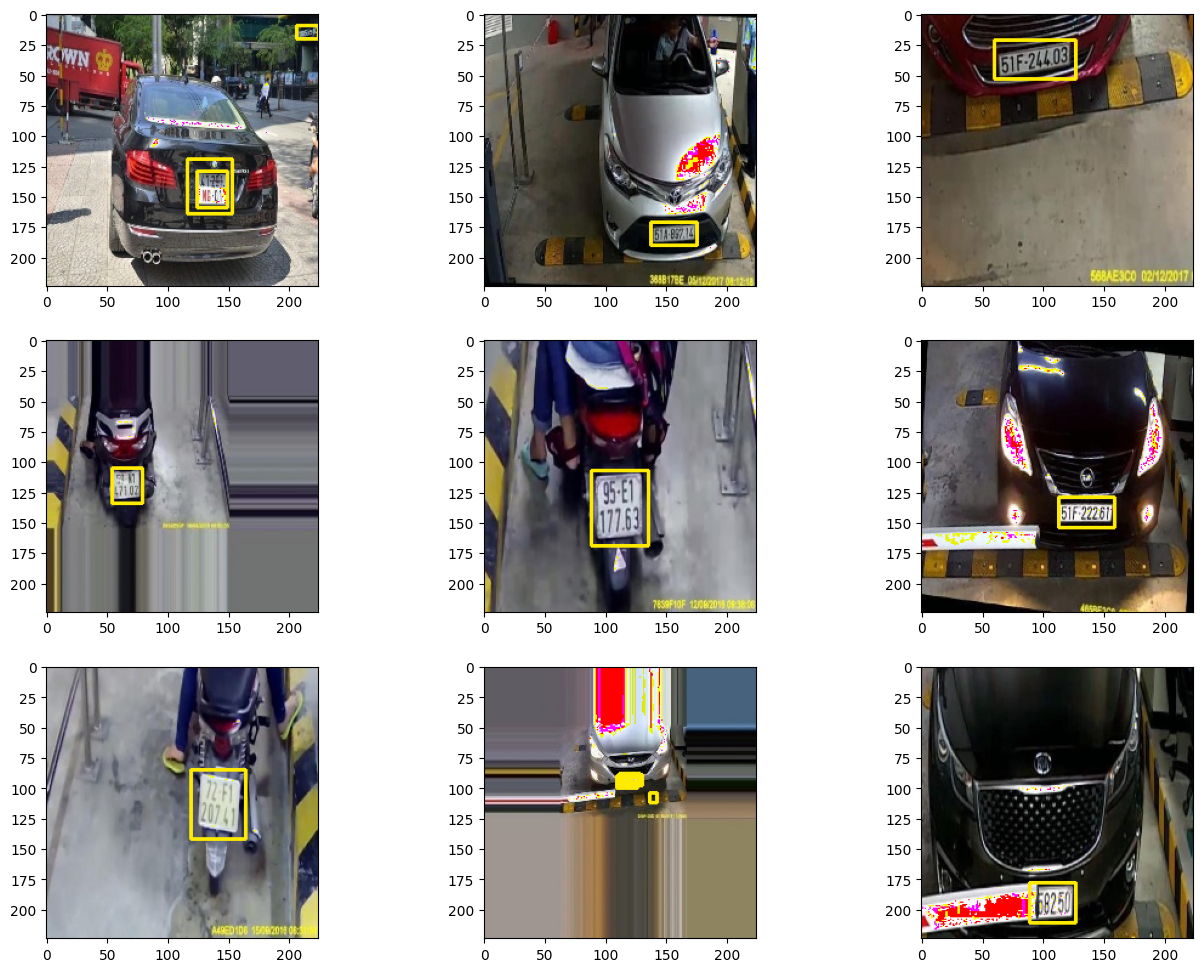

In [10]:
display_images_and_targets(test_images, test_predictions)